In [3]:
import geopandas as gpd
import numpy as np
import shapely

In [4]:
N_SQUARES = 40
SQUARE_WIDTH = 0.2
N_CLASSES = 4

Create dummy data

<Axes: >

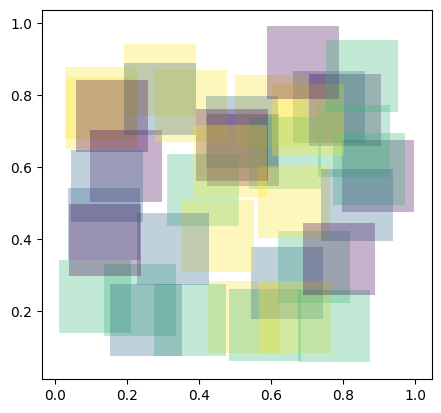

In [5]:
tl_corners = np.random.random((N_SQUARES, 2)) * (1 - SQUARE_WIDTH)
boxes = [shapely.box(tl[0], tl[1], tl[0] + SQUARE_WIDTH, tl[1] + SQUARE_WIDTH) for tl in tl_corners]
classes = np.random.randint(0, N_CLASSES, size=N_SQUARES)

classified_polygons = gpd.GeoDataFrame({"geometry": boxes, "classes": classes})
classified_polygons.plot("classes",alpha=0.3)

0    0.008801
1    0.003112
2    0.001524
Name: area, dtype: float64
[2, 1, 0]
      3    2    1    0
0   1.0  1.0  1.0  1.0
1   2.0  1.0  1.0  1.0
2   1.0  2.0  1.0  1.0
3   1.0  1.0  1.0  2.0
4   2.0  1.0  1.0  2.0
5   1.0  2.0  1.0  2.0
6   1.0  1.0  NaN  1.0
7   2.0  1.0  NaN  1.0
8   1.0  2.0  NaN  1.0
9   1.0  1.0  NaN  2.0
10  2.0  1.0  NaN  2.0
11  1.0  2.0  NaN  2.0
12  1.0  1.0  1.0  NaN
13  2.0  1.0  1.0  NaN
14  1.0  2.0  1.0  NaN
15  2.0  2.0  1.0  NaN
16  1.0  3.0  1.0  NaN
17  1.0  NaN  1.0  1.0
18  2.0  NaN  1.0  1.0
19  3.0  NaN  1.0  1.0
20  1.0  NaN  1.0  2.0
21  2.0  NaN  1.0  2.0
22  1.0  NaN  NaN  1.0
23  2.0  NaN  NaN  1.0
24  1.0  NaN  NaN  2.0
25  2.0  NaN  NaN  2.0
26  1.0  NaN  1.0  NaN
27  2.0  NaN  1.0  NaN
28  3.0  NaN  1.0  NaN
29  1.0  1.0  NaN  NaN
30  2.0  1.0  NaN  NaN
31  1.0  2.0  NaN  NaN
32  NaN  1.0  1.0  1.0
33  NaN  2.0  1.0  1.0
34  NaN  1.0  1.0  2.0
35  NaN  2.0  1.0  2.0
36  NaN  1.0  NaN  1.0
37  NaN  2.0  NaN  1.0
38  NaN  2.0  NaN  2.0
3

/ofo-share/repos-david/conda/envs/scientific-python-utils/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


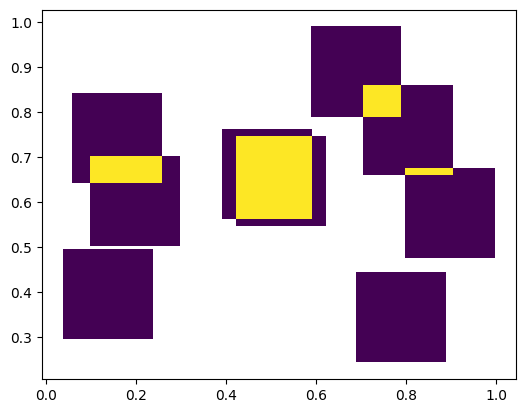

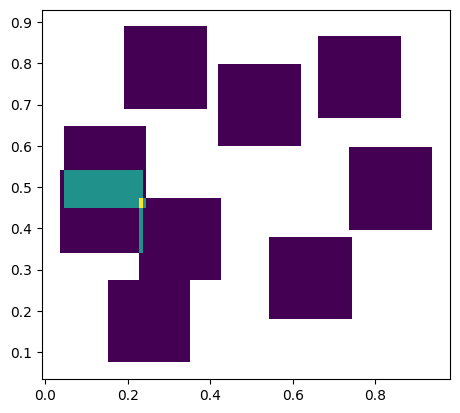

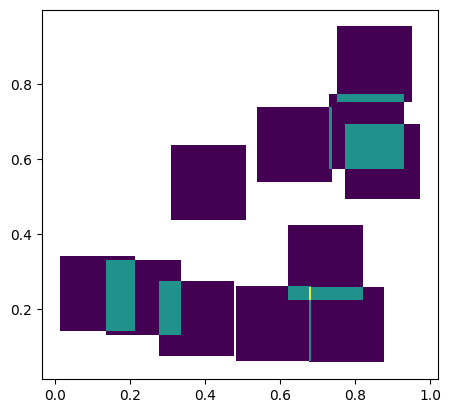

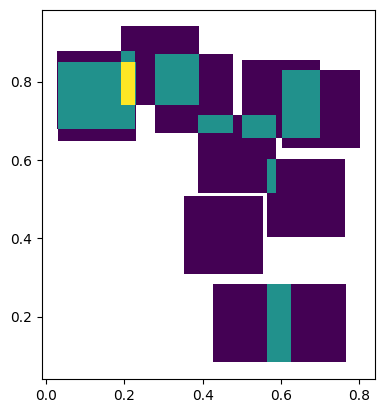

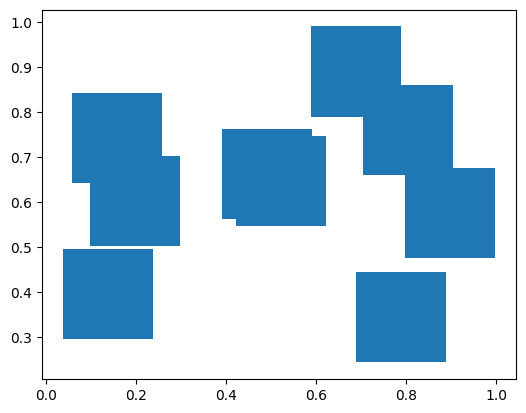

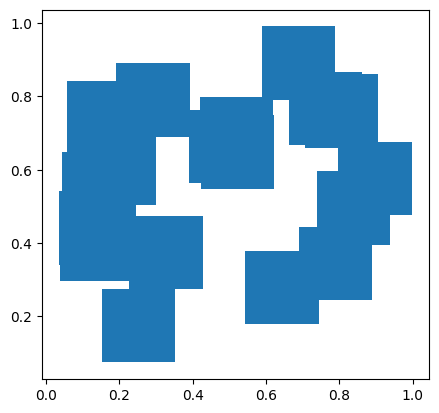

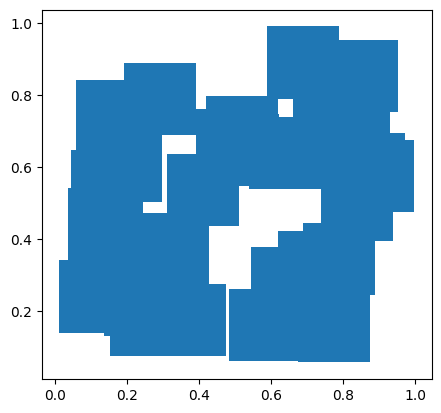

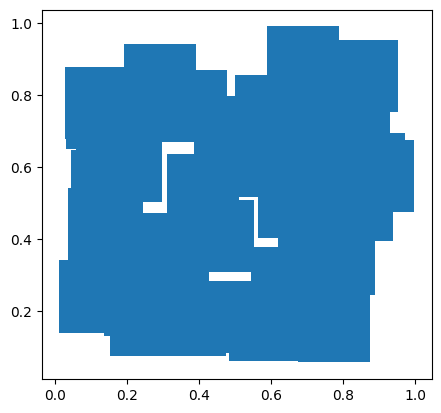

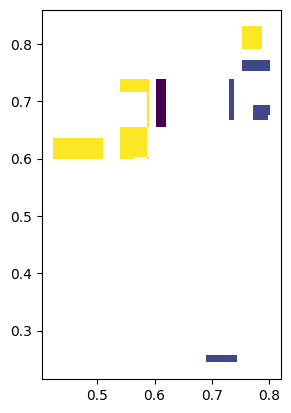

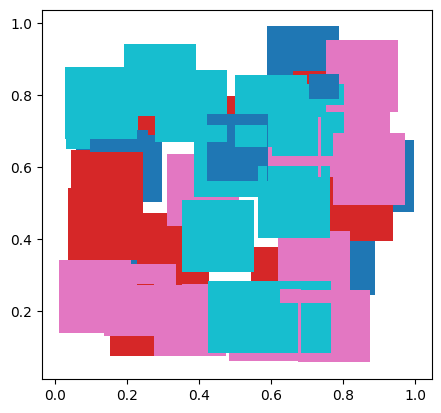

In [6]:
import matplotlib.pyplot as plt
def merge_classified_polygons(classified_polygons, class_column=None):
    grouped = {k[0]:v for k, v in classified_polygons.groupby([class_column])}

    unique_classes = list(grouped.keys())

    counts_overlays = []

    for k, v in grouped.items():
        v.drop("classes", axis=1, inplace=True)
        v["counts"] = 1

        overlay = v.iloc[0:1]

        for i in range(1, len(v)):
            overlay = gpd.overlay(overlay, v.iloc[i:i+1], how="union")
            overlay.fillna(0, inplace=True)
            overlay["counts"] = overlay["counts_1"] + overlay["counts_2"]
            overlay.drop(["counts_1", "counts_2"], axis=1, inplace=True)
        overlay = overlay.dissolve("counts", as_index=False)
        overlay[k] = overlay["counts"]
        overlay.plot("counts")
        overlay.drop("counts", axis=1, inplace=True)

        counts_overlays.append(overlay)

    votes_per_class = counts_overlays[0]
    votes_per_class.plot()

    for single_class_overlay in counts_overlays[1:]:
        votes_per_class = gpd.overlay(votes_per_class, single_class_overlay, how="union")
        votes_per_class.plot()

    class_counts_matrix = votes_per_class[unique_classes].values
    max_class_counts = np.max(class_counts_matrix, axis=1, keepdims=True)

    # Find rows where one class has the most votes
    one_max_class = np.sum(max_class_counts == class_counts_matrix, axis=1) == 1

    # Extract rows where one class has the most votes
    rows_with_one_class = votes_per_class.iloc[one_max_class]
    # Label them with the max class
    rows_with_one_class["max_class"] = rows_with_one_class[unique_classes].idxmax(axis=1)
    # Dissolve all polygons so we have one (multi)polygon per class
    rows_with_one_class = rows_with_one_class.dissolve("max_class", as_index=False)
    # Compute the area of each
    rows_with_one_class["area"] = rows_with_one_class.area
    rows_with_one_class.plot("area")


    print(rows_with_one_class["area"])
    sorted_inds = (rows_with_one_class["area"]).argsort()
    sorted_classes = rows_with_one_class.index[sorted_inds].tolist()
    print(sorted_classes)

    # Determine which classes (if any) have no non-overlapping regions. Add them to the start of the
    # list
    zero_area_classes = [c for c in unique_classes if c not in sorted_classes]
    # Prepend the classes to the beginning of the list of sorted classes
    sorted_classes = zero_area_classes + sorted_classes

    # Get the new order of column names
    print(votes_per_class[sorted_classes])
    max_class = votes_per_class[sorted_classes].idxmax(axis=1)
    print(max_class)
    votes_per_class["max_class"] = max_class
    votes_per_class.plot("max_class")

merge_classified_polygons(classified_polygons=classified_polygons, class_column="classes")